In [18]:
%matplotlib inline

from IPython.display import Image,display

from numpy import pi

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

First I'll create $|0><0|$ and $|1><1|$ and $|01><10|$ , they will be needed in the future.

In [19]:
zeromat = basis(2,0)*basis(2,0).trans()
oneomat = basis(2,1)* basis(2,1).trans()
display(zeromat,oneomat)
zero_one = tensor(basis(2,0),basis(2,1)) # |01>
zero_onemat = zero_one*zero_one.trans()
display(zero_onemat)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  0.]]

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.  0.]
 [ 0.  1.]]

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

## Building hamiltonian for the 2-SAT formula
I chose the formula 
$(x_1\vee \overline{x_2})
\wedge
(x_2\vee \overline{x_3})
\wedge
(x_3\vee \overline{x_1})
\wedge
(x_1\vee x_1)
$
the only solution for this formula is $x_1 =1 \quad   x_2 = 1 \quad  x_3 = 1$
Which will be encoded in the state $|111>$

Starting with $(x_1\vee \overline{x_2})$ this is equivalent to 
$|01><01|\otimes ID_3$

In [20]:
hamiltonian_terms = [] 
term1_hamiltonian = tensor(zero_onemat,qeye(2))
hamiltonian_terms.append(term1_hamiltonian)
display(term1_hamiltonian)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

The second term is $(x_2\vee \overline{x_3})$
So that will be 
$ID_1\otimes|01><01$

The third is 
$(x_3\vee \overline{x_1})$
will be
$|1><1| \otimes ID_2\otimes |0><0$

And finaly for $(x_1\vee x_1)$
We will have 
$|0><0| \otimes ID_{23}$


In [21]:
hamiltonian_terms.append(tensor(qeye(2),zero_onemat))
hamiltonian_terms.append(tensor(oneomat,qeye(2),zeromat))
hamiltonian_terms.append(tensor(zeromat,qeye(2),qeye(2)))

The final hamiltonian is the sum of this local terms

In [22]:
LH = sum(hamiltonian_terms)
display(LH)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Let's examine the ground states of the local hamiltonian LH 

In [23]:
print ("Energy %s" % LH.groundstate()[0])
print ("State")
display(LH.groundstate()[1])

Energy 0.0
State


Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = [8, 1], type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]]

Indeed we got the $|111>$ state , just as we expected.

# Now lets Try doing some adiabatic computation

In [7]:
from IPython.core.debugger import Tracer

def simulate_adiabatic_process(tlist,H0,H1,rho0,draw):
    
    args = {'t_max': max(tlist)}
    h_t = [[H0, lambda t, args : (args['t_max']-t)/args['t_max']],
           [H1, lambda t, args : t/args['t_max']]]
    #
    # callback function for each time-step
    #
    N = 2
    M = 2
    evals_mat = np.zeros((len(tlist),M))
    P_mat = np.zeros((len(tlist),M))

    idx = [0]
    def process_rho(tau, psi):

        # evaluate the Hamiltonian with gradually switched on interaction 
        H = Qobj.evaluate(h_t, tau, args)

        # find the M lowest eigenvalues of the system
        evals, ekets = H.eigenstates(eigvals=M)

        evals_mat[idx[0],:] = np.real(evals)

        # find the overlap between the eigenstates and psi 
        for n, eket in enumerate(ekets):
            P_mat[idx[0],n] = abs((eket.dag().data * psi.data)[0,0])**2    

        idx[0] += 1

    output = sesolve(H=h_t,
                 rho0=rho0,
                 tlist=tlist,
                 e_ops=process_rho,
                 args = args)
    #rc('font', family='serif')
    #rc('font', size='10')
    if draw:
        fig, axes = plt.subplots(2, 1, figsize=(12,10))

        #
        # plot the energy eigenvalues
        #

        # first draw thin lines outlining the energy spectrum
        for n in range(len(evals_mat[0,:])):
            ls,lw = ('b',1) if n == 0 else ('k', 0.25)
            axes[0].plot(tlist/max(tlist), evals_mat[:,n] / (2*pi), ls, lw=lw)


        # second, draw line that encode the occupation probability of each state in 
        # its linewidth. thicker line => high occupation probability.
        for idx in range(len(tlist)-1):
            for n in range(len(P_mat[0,:])):
                lw = 0.5 + 4*P_mat[idx,n]    
                if lw > 0.55:
                   axes[0].plot(np.array([tlist[idx], tlist[idx+1]])/ max(tlist), 
                                np.array([evals_mat[idx,n], evals_mat[idx+1,n]])/(2*pi), 
                                'r', linewidth=lw)    
        axes[0].set_xlabel(r'$\tau$')
        axes[0].set_ylabel('Eigenenergies')
        axes[0].set_title("Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M,N)
                        + "The occupation probabilities are encoded in the red line widths.")

        #
        # plot the occupation probabilities for the few lowest eigenstates
        #
        for n in range(len(P_mat[0,:])):
            if n == 0:
                axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n], 'r', linewidth=2)
            else:
                axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n])

        axes[1].set_xlabel(r'$\tau$')
        axes[1].set_ylabel('Occupation probability')
        axes[1].set_title("Occupation probability of the %d lowest " % M +
                          "eigenstates for a chain of %d spins" % N)
        axes[1].legend(("Ground state",));

    return P_mat,evals_mat

## First we need to create a simple hamiltonian for which we know the ground state 
I will take the hamiltonian that gets 0 energy on $|000>$ and 1 on the rest of the computational basis.

In [8]:
zero3 = tensor([basis(2,0)]*3)
zero3_mat = zero3*zero3.trans()
id3 = tensor([qeye(2)]*3)
simple_ham = id3-zero3_mat 
simple_ham

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]

In [9]:
psi0 = simple_ham.groundstate()[1]
simple_ham.groundstate()

(0.0, Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = [8, 1], type = ket
 Qobj data =
 [[ 1.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]])

As expected , the ground state is |000>

Now we need to make sure that the two hamiltonians are not commuting, so I apply $H^{\otimes 3}$ on the first hamiltonian and it's groud state.

In [10]:
had_simple_ham = tensor([hadamard_transform()] * 3) * simple_ham * tensor([hadamard_transform()] * 3)
h3psi0 = tensor([hadamard_transform()] * 3) * psi0

In [11]:
h3psi0

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = [8, 1], type = ket
Qobj data =
[[ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [ 0.35355339]]

In [12]:
tlist = np.linspace(0, 100, 100)
P_mat,evals_mat =simulate_adiabatic_process(tlist,had_simple_ham,LH,h3psi0,False)

In [13]:
100//2

50

## Landau zenner approximation
In this the following lines of code, I will attemp to demonstrate the exponential decay in probability of crossing (diabatic transition probability) that the Landau-Zenner formula predicts :
### LZ-formula:
$P_D = e^ {-2\pi\Gamma}$
where 
$\Gamma = \frac{a^2}{\hbar|\alpha|}$

In [14]:
#Compute list of probabilities:
list_of_pr_for_psi0_in_end = []
list_of_pr_for_psi0_in_mid = []
for speed in range(1,100):
    tlist = np.linspace(0, speed, 100)
    P_mat,evals_mat =simulate_adiabatic_process(tlist,had_simple_ham,LH,h3psi0,False)
    list_of_pr_for_psi0_in_mid.append(P_mat[P_mat.shape[0]//2][0])
    list_of_pr_for_psi0_in_end.append(P_mat[-1][0])
    
pr_of_jump_in_mid = np.ones(99)-list_of_pr_for_psi0_in_mid    
pr_of_jump_in_end = np.ones(99)-list_of_pr_for_psi0_in_end

In [15]:
had_simple_ham

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 0.875 -0.125 -0.125 -0.125 -0.125 -0.125 -0.125 -0.125]
 [-0.125  0.875 -0.125 -0.125 -0.125 -0.125 -0.125 -0.125]
 [-0.125 -0.125  0.875 -0.125 -0.125 -0.125 -0.125 -0.125]
 [-0.125 -0.125 -0.125  0.875 -0.125 -0.125 -0.125 -0.125]
 [-0.125 -0.125 -0.125 -0.125  0.875 -0.125 -0.125 -0.125]
 [-0.125 -0.125 -0.125 -0.125 -0.125  0.875 -0.125 -0.125]
 [-0.125 -0.125 -0.125 -0.125 -0.125 -0.125  0.875 -0.125]
 [-0.125 -0.125 -0.125 -0.125 -0.125 -0.125 -0.125  0.875]]

In [16]:
#Curve fit to exponential decay
from scipy.optimize import curve_fit
def exp_fit(x,a,b):
    return a*np.exp(-x*b)

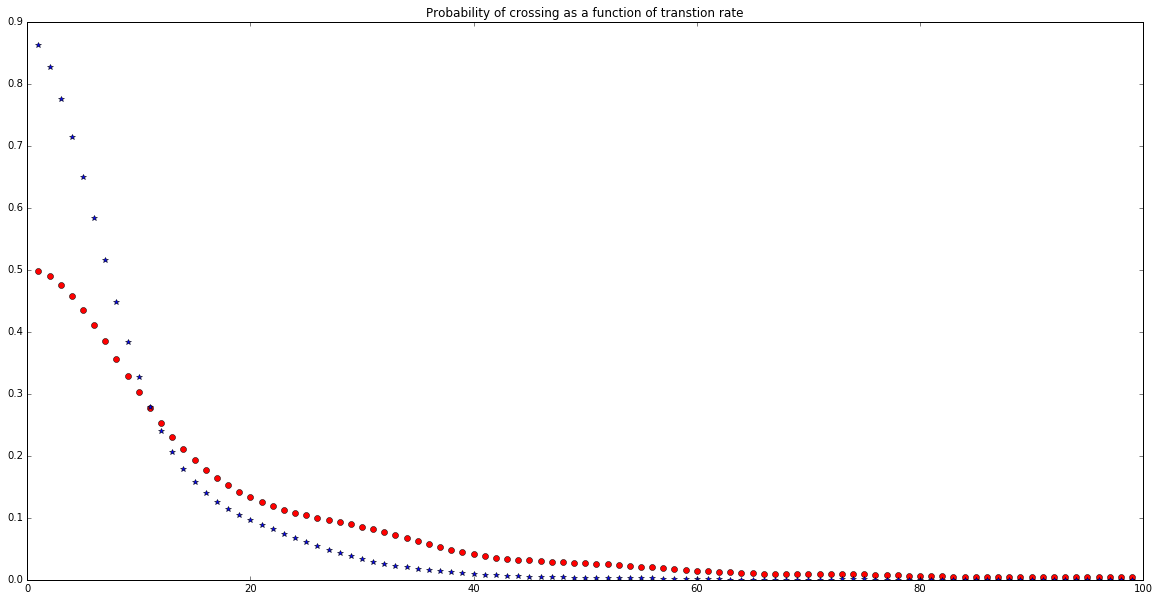

NameError: name 'Γ' is not defined

In [24]:
plt.figure(figsize=(20,10))
(end_a,end_Γ),cov = curve_fit(exp_fit,tlist[1:],pr_of_jump_in_end)
(mid_a,mid_b),cov= curve_fit(exp_fit,tlist[1:],pr_of_jump_in_mid)
plt.plot(tlist[1:],pr_of_jump_in_mid,'o',color='red')

plt.plot(tlist[1:],pr_of_jump_in_end,'*',color='blue')
# plt.plot(tlist[1:],exp_fit(tlist[1:],end_a,end_Γ),color='blue')


plt.title("Probability of crossing as a function of transtion rate")
plt.show()
print("Γ=", Γ)

So we find out that $\Gamma$ =0.11592386620626052 

In [ ]:
a

In [ ]:
# def generate_random_ham(dim, normalize = True):
#     """Generate hamiltonian, with the specified dimesions """
#     size = 2**dim
#     rand_mat = np.random.rand(size**2)
#     rand_phase = np.exp(-1J*2*pi*np.random.rand(size**2))
#     rand_complex_vector = rand_mat * rand_phase
#     rand_complex_matrix = rand_complex_vector.reshape((size, size))
#     m = np.tril(rand_complex_matrix) +\
#         np.matrix(np.tril(rand_complex_matrix)).getH()
#     if normalize:
#         m = m/np.linalg.norm(m)
#     return Qobj(m,dims=(size,size))


# can just use rand_herm(size)

In [ ]:
# def alternate_sweep(tlist,H_init,H_alternate,H_final,rho0,draw):
#     """
#     Simulates a sweep that alternates between two hamiltonians
#     """
#     args = {'t_max': max(tlist)}
#     #
#     # callback function for each time-step
#     #
#     N = 2
#     M = 2
#     evals_mat = np.zeros((len(tlist),M))
#     P_mat = np.zeros((len(tlist),M))
    
    
#     def alternate_hams(tau,args, H_init, H_alternate, H_final):
#         return (t%2 * H_init* (args['t_max']-t)/args['t_max'] +
#                 (t%2+1)* H_alternate * (args['t_max']-t)/args['t_max'] +
#                 H_final*t/args['t_max'])
    
    

#     def process_rho(tau, psi):
#         # evaluate the Hamiltonian with gradually switched on interaction 
#         #H = Qobj.evaluate(h_t, tau, args)
#         H = alternate_hams(tau, args, H_init, H_alternate, H_final)

#         # find the M lowest eigenvalues of the system
#         evals, ekets = H.eigenstates(eigvals=M)

#         evals_mat[idx[0],:] = np.real(evals)

#         # find the overlap between the eigenstates and psi 
#         for n, eket in enumerate(ekets):
#             P_mat[idx[0],n] = abs((eket.dag().data * psi.data)[0,0])**2    
            
#     output = sesolve(H=h_t,
#                  rho0=rho0,
#                  tlist=tlist,
#                  e_ops=process_rho,
#                  args = args)
#     #rc('font', family='serif')
#     #rc('font', size='10')
#     if draw:
#         fig, axes = plt.subplots(2, 1, figsize=(12,10))

#         #
#         # plot the energy eigenvalues
#         #

#         # first draw thin lines outlining the energy spectrum
#         for n in range(len(evals_mat[0,:])):
#             ls,lw = ('b',1) if n == 0 else ('k', 0.25)
#             axes[0].plot(tlist/max(tlist), evals_mat[:,n] / (2*pi), ls, lw=lw)


#         # second, draw line that encode the occupation probability of each state in 
#         # its linewidth. thicker line => high occupation probability.
#         for idx in range(len(tlist)-1):
#             for n in range(len(P_mat[0,:])):
#                 lw = 0.5 + 4*P_mat[idx,n]    
#                 if lw > 0.55:
#                    axes[0].plot(np.array([tlist[idx], tlist[idx+1]])/ max(tlist), 
#                                 np.array([evals_mat[idx,n], evals_mat[idx+1,n]])/(2*pi), 
#                                 'r', linewidth=lw)    
#         axes[0].set_xlabel(r'$\tau$')
#         axes[0].set_ylabel('Eigenenergies')
#         axes[0].set_title("Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M,N)
#                         + "The occupation probabilities are encoded in the red line widths.")

#         #
#         # plot the occupation probabilities for the few lowest eigenstates
#         #
#         for n in range(len(P_mat[0,:])):
#             if n == 0:
#                 axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n], 'r', linewidth=2)
#             else:
#                 axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n])

#         axes[1].set_xlabel(r'$\tau$')
#         axes[1].set_ylabel('Occupation probability')
#         axes[1].set_title("Occupation probability of the %d lowest " % M +
#                           "eigenstates for a chain of %d spins" % N)
#         axes[1].legend(("Ground state",));

#     return P_mat,evals_mat

In [ ]:
# t = 4
H_init = had_simple_ham
H_alternate = Qobj(rand_herm(8),dims=[[2,2,2],[2,2,2]])
H_final = LH
args = {'t_max': max(tlist)}

# h_t = [
#     [ H_init, lambda t, args : (args['t_max']-t)/args['t_max'] ] ,
#     [ H_alternate, lambda t, args : t/args['t_max'] ],
#        [ H_final, lambda t, args : t/args['t_max'] ],
    
# ]
# Qobj.evaluate(h_t, 0, args)


# (t%2 * H_init* (args['t_max']-t)/args['t_max'] +
#                 (t%2+1)* H_alternate * (args['t_max']-t)/args['t_max'] +
#                 H_final*t/args['t_max'])

In [ ]:
# def generate_random_sweep_ham(H_init,
#                               H_final,
#                               H_rand = rand_herm(H_init.shape[0],dims=H_init.dims)):
#     H= [[had_simple_ham,'(t_max-t)/t_max'],
#          [H_alternate, 'np.float(np.where(tlist==t)[0][0]%2)*(t_max-t)/t_max'],
#          [H_final, 't/t_max']]
#     return H





def generate_random_sweep_ham(H_init,
                              H_final,
                              H_rand = rand_herm(H_init.shape[0],dims=H_init.dims)):
    H= [[had_simple_ham,'(t_max-t)/t_max'],
         [H_alternate, 'np.random.choice((0,1))*(t_max-t)/t_max'],
         [H_final, 't/t_max']]
    return H

In [ ]:
h_t  = generate_random_sweep_ham(had_simple_ham, LH)

In [ ]:
Qobj.evaluate(h_t, tlist[1], args)
args

In [ ]:
def simulate_adiabatic_process2(tlist, h_t, args, rho0, draw):

    #
    # callback function for each time-step
    #
    N = 2
    M = 2
    evals_mat = np.zeros((len(tlist),M))
    P_mat = np.zeros((len(tlist),M))

    idx = [0]
    def process_rho(tau, psi):

        # evaluate the Hamiltonian with gradually switched on interaction 
        H = Qobj.evaluate(h_t, tau, args)

        # find the M lowest eigenvalues of the system
        evals, ekets = H.eigenstates(eigvals=M)

        evals_mat[idx[0],:] = np.real(evals)

        # find the overlap between the eigenstates and psi 
        for n, eket in enumerate(ekets):
            P_mat[idx[0],n] = abs((eket.dag().data * psi.data)[0,0])**2    

        idx[0] += 1

    output = sesolve(H=h_t,
                 rho0=rho0,
                 tlist=tlist,
                 e_ops=process_rho,
                 args = args)
    #rc('font', family='serif')
    #rc('font', size='10')
    if draw:
        fig, axes = plt.subplots(2, 1, figsize=(12,10))

        #
        # plot the energy eigenvalues
        #

        # first draw thin lines outlining the energy spectrum
        for n in range(len(evals_mat[0,:])):
            ls,lw = ('b',1) if n == 0 else ('k', 0.25)
            axes[0].plot(tlist/max(tlist), evals_mat[:,n] / (2*pi), ls, lw=lw)


        # second, draw line that encode the occupation probability of each state in 
        # its linewidth. thicker line => high occupation probability.
        for idx in range(len(tlist)-1):
            for n in range(len(P_mat[0,:])):
                lw = 0.5 + 4*P_mat[idx,n]    
                if lw > 0.55:
                   axes[0].plot(np.array([tlist[idx], tlist[idx+1]])/ max(tlist), 
                                np.array([evals_mat[idx,n], evals_mat[idx+1,n]])/(2*pi), 
                                'r', linewidth=lw)    
        axes[0].set_xlabel(r'$\tau$')
        axes[0].set_ylabel('Eigenenergies')
        axes[0].set_title("Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M,N)
                        + "The occupation probabilities are encoded in the red line widths.")

        #
        # plot the occupation probabilities for the few lowest eigenstates
        #
        for n in range(len(P_mat[0,:])):
            if n == 0:
                axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n], 'r', linewidth=2)
            else:
                axes[1].plot(tlist/max(tlist), 0 + P_mat[:,n])

        axes[1].set_xlabel(r'$\tau$')
        axes[1].set_ylabel('Occupation probability')
        axes[1].set_title("Occupation probability of the %d lowest " % M +
                          "eigenstates for a chain of %d spins" % N)
        axes[1].legend(("Ground state",));

    return P_mat,evals_mat

In [ ]:
args = {'t_max': max(tlist),'tlist':tlist}
P_mat,evals_mat =simulate_adiabatic_process2(tlist, h_t, args, h3psi0, False)

In [ ]:
h_t = generate_random_sweep_ham(simple_ham, LH)
# h_t= [[had_simple_ham,'(t_max-t)/t_max'],[H_final, 't/t_max']]

#Compute list of probabilities:
list_of_pr_for_psi0_in_end = []
list_of_pr_for_psi0_in_mid = []
for speed in range(1,100):
    tlist = np.linspace(0, speed, 100)
    args = {'t_max': max(tlist),'tlist':tlist}
    P_mat,evals_mat =simulate_adiabatic_process2(tlist, h_t, args, h3psi0, False)
    list_of_pr_for_psi0_in_mid.append(P_mat[P_mat.shape[0]//2][0])
    list_of_pr_for_psi0_in_end.append(P_mat[-1][0])
    
pr_of_jump_in_mid = np.ones(99)-list_of_pr_for_psi0_in_mid    
pr_of_jump_in_end = np.ones(99)-list_of_pr_for_psi0_in_end



plt.figure(figsize=(20,10))
(end_a,end_Γ),cov = curve_fit(exp_fit,tlist[1:],pr_of_jump_in_end)
(mid_a,mid_b),cov= curve_fit(exp_fit,tlist[1:],pr_of_jump_in_mid)
plt.plot(tlist[1:],pr_of_jump_in_mid,'o',color='red')

plt.plot(tlist[1:],pr_of_jump_in_end,'*',color='blue')
plt.plot(tlist[1:],exp_fit(tlist[1:],end_a,end_Γ),color='blue')


plt.title("Probability of crossing as a function of transtion rate")
plt.show()
print("Γ=", Γ)

In [ ]:
had_simple_ham.norm()

In [ ]:
LH.norm()

# Examining the behaviour of random hamiltonians 

I want to compare the high-speed reigon with a  random hamiltonian applied and without.

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(tlist[1:],pr_of_jump_in_end,'*',color='blue')